In [1]:
!pip install scikit-optimize==0.9.0

In [2]:
!pip install vecstack==0.4.0

In [3]:
!pip install keras-tuner==1.0.2

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from vecstack import StackingTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, losses, metrics, models
import tensorflow as tf
from kerastuner import HyperParameters
import kerastuner as kt
import random

In [5]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
X = df.drop(columns=['charges'])  # 독립 변수들
y = df['charges']  # 종속 변수

# train-test split을 수행합니다
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 확인
print("Train set X shape:", X_train.shape)
print("Test set X shape:", X_test.shape)
print("Train set y shape:", y_train.shape)
print("Test set y shape:", y_test.shape)

Train set X shape: (1070, 6)
Test set X shape: (268, 6)
Train set y shape: (1070,)
Test set y shape: (268,)


In [7]:
# 변수가 다른 변수들과 스케일이 달라서 영향을 많이 받아 학습이 제대로 이루어지지 않을 수 있어서 정규화 수행.
# 이상치에 민감하지 않도록 MinMaxScaler를 사용하여 정규화.

# Pipeline 정의
# 수치형 변수의 전처리
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# 범주형 변수의 전처리
categorical_transformer = Pipeline(steps=[

    # 만약 학습할 때는 있지만 테스트 데이터에서 새로운 범주가 발생할 경우
    # handle_unknown='ignore' 옵션을 통해 이를 무시하고 변환 작업을 진행
    # 이 옵션을 사용함으로써 모델이 학습할 때와 테스트할 때의 일관성을 유지하면서 처리할 수 있음.
    # (이름, 변환기)
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 전체 전처리 파이프라인 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['age', 'bmi', 'children']),  # 수치형 변수
        ('cat', categorical_transformer, ['sex', 'smoker', 'region'])  # 범주형 변수
    ])

# 최종 Pipeline 정의 (전처리 + 모델)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Train 데이터에 대해서만 fit을 적용
pipeline.fit(X_train)

# Train 데이터와 Test 데이터 각각에 대해 transform 수행
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# 컬럼명 재구성
# 수치형 변수와 범주형 변수의 컬럼명을 다시 가져오기
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names(['sex', 'smoker', 'region'])

# 전체 특성의 컬럼명 재구성
feature_names = list(numeric_features) + list(categorical_features)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [8]:
X_train

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.608696,0.107345,0.4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.630435,0.224913,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.739130,0.239440,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.456522,0.493947,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.782609,0.148238,0.6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1065,0.000000,0.414044,0.8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1066,0.456522,0.212806,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1067,0.869565,0.247915,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1068,0.413043,0.851224,0.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


GradientBoostingRegressor RMSE: 4329.2109
R2 Score on Test set for GradientBoostingRegressor: 0.879277




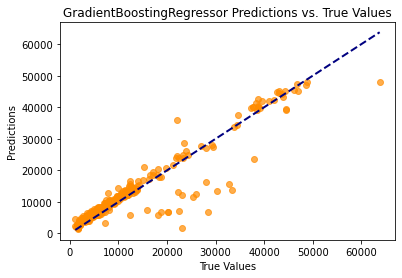

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13346.089733
LightGBMRegressor RMSE: 4571.5871
R2 Score on Test set for LightGBMRegressor: 0.865381




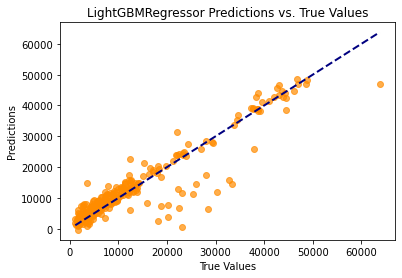

RandomForestRegressor RMSE: 4652.8020
R2 Score on Test set for RandomForestRegressor: 0.860556




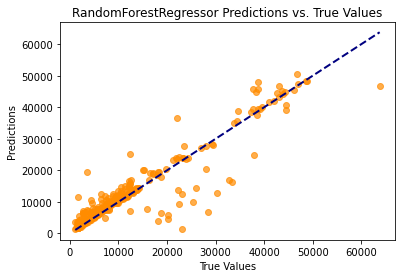

In [9]:
models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
    'LightGBMRegressor': LGBMRegressor(),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),    
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'{model_name} RMSE: {rmse:.4f}')  # RMSE 출력
    print(f"R2 Score on Test set for {model_name}: {model.score(X_test, y_test):.6f}")  # 테스트 세트 R2 Score
    print("\n=============================\n")    
    
    # 예측 결과와 실제 값의 산점도 그리기
    plt.figure()
    plt.scatter(y_test, pred, color='darkorange', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='navy', lw=2, linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'{model_name} Predictions vs. True Values')
    plt.show()

Optimizing GradientBoostingRegressor...
The best parameters are  OrderedDict([('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 447), ('subsample', 0.5)]) 

GradientBoostingRegressor RMSE: 4311.7676
R2 Score on Training set for GradientBoostingRegressor: 0.850064
R2 Score on Test set for GradientBoostingRegressor: 0.880248




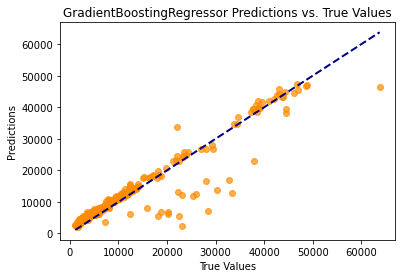

Optimizing LightGBMRegressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13346.089733
The best parameters are  OrderedDict([('learning_rate', 0.01), ('n_estimators', 332), ('num_leaves', 20), ('subsample', 0.5)]) 

LightGBMRegressor RMSE: 4387.5083
R2 Score on Training set for LightGBMRegressor: 0.842012
R2 Score on Test set for LightGBMRegressor: 0.876004




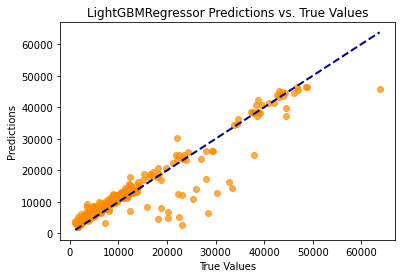

Optimizing RandomForestRegressor...
The best parameters are  OrderedDict([('max_depth', 4), ('min_samples_leaf', 11), ('min_samples_split', 20), ('n_estimators', 361)]) 

RandomForestRegressor RMSE: 4408.5625
R2 Score on Training set for RandomForestRegressor: 0.847766
R2 Score on Test set for RandomForestRegressor: 0.874811




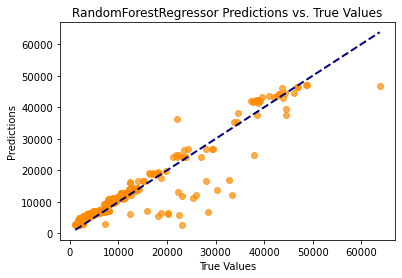

Wall time: 10min 16s


In [10]:
%%time
models = {
    'GradientBoostingRegressor': (GradientBoostingRegressor(random_state=0), {
        'n_estimators': Integer(100, 500),  # 트리 개수
        'max_depth': Integer(3, 12),          # 최대 깊이
        'learning_rate': Categorical([0.01, 0.1, 0.2, 0.3, 0.4]),  # 학습률
        'subsample': Categorical([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # 샘플 비율
    }),
    'LightGBMRegressor': (LGBMRegressor(random_state=0), {
        'n_estimators': Integer(100, 500),  # 트리 개수
        'learning_rate': Categorical([0.01, 0.1, 0.2, 0.3, 0.4]),  # 학습률
        'subsample': Categorical([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),  # 샘플 비율
        'num_leaves': Integer(20, 100)  # 리프 노드의 수
    }),
    'RandomForestRegressor': (RandomForestRegressor(random_state=0), {
        'n_estimators': Integer(100, 500),  # 트리 개수
        'max_depth': Integer(3, 20),          # 최대 깊이
        'min_samples_split': Integer(2, 20),  # 최소 샘플 분할 수
        'min_samples_leaf': Integer(1, 20)  # 최소 리프 노드 샘플 수
    })
}

# 최적의 하이퍼파라미터를 저장할 리스트
estimators = []

# 각 모델에 대해 베이지안 최적화를 수행하고 결과를 출력합니다.
for model_name, (estimator, param) in models.items():
    print(f"Optimizing {model_name}...")  # 최적화 모델 이름 출력
    
    # BayesSearchCV 객체를 생성합니다.
    hpo = BayesSearchCV(
        random_state=0,
        estimator=estimator,
        search_spaces=param,  # 하이퍼파라미터
        refit=True,  # 최적 파라미터로 다시 학습
        n_jobs=-1,  # 모든 CPU 코어 사용
        n_iter=72,  # 최적화 반복 횟수
        cv=5  # 교차 검증 folds 수
    )

    # 최적화 수행
    hpo.fit(X_train, y_train)
    
    # 최적 파라미터 출력
    print('The best parameters are ', hpo.best_params_, '\n')
    
    # 모델 인스턴스 생성
    best_params = hpo.best_params_
    if model_name == 'GradientBoostingRegressor':
        model_instance = GradientBoostingRegressor(
            random_state=0,
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample']
        )
    elif model_name == 'LightGBMRegressor':
        model_instance = LGBMRegressor(
            random_state=0,
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            num_leaves=best_params['num_leaves']
        )
    elif model_name == 'RandomForestRegressor':
        model_instance = RandomForestRegressor(
            random_state=0,
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf']
        )

    # 최적 하이퍼파라미터와 함께 모델 인스턴스를 튜플로 저장
    estimators.append((model_name, model_instance))
    
    # 예측 및 성능 지표 계산
    pred = hpo.predict(X_test)  # 테스트 세트에 대한 예측
    rmse = np.sqrt(mean_squared_error(y_test, pred))  # RMSE 계산
    print(f'{model_name} RMSE: {rmse:.4f}')  # RMSE 출력
    print(f"R2 Score on Training set for {model_name}: {hpo.best_score_:.6f}")  # 학습 세트 R2 Score
    print(f"R2 Score on Test set for {model_name}: {hpo.score(X_test, y_test):.6f}")  # 테스트 세트 R2 Score
    print("\n=============================\n")
    
    # 예측 결과와 실제 값의 산점도 그리기
    plt.figure()
    plt.scatter(y_test, pred, color='darkorange', alpha=0.7)  # 실제 값과 예측 값 산점도
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='navy', lw=2, linestyle='--')  # 대각선 추가
    plt.xlabel('True Values')  # x축 레이블
    plt.ylabel('Predictions')  # y축 레이블
    plt.title(f'{model_name} Predictions vs. True Values')  # 그래프 제목
    plt.show()  # 그래프 표시

task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [3]

estimator  0: [GradientBoostingRegressor: GradientBoostingRegressor]
    fold  0:  [2801.36287656]
    fold  1:  [2472.12912413]
    fold  2:  [2634.94162550]
    fold  3:  [2524.42432581]
    ----
    MEAN:     [2608.21448800] + [126.05619523]

estimator  1: [LightGBMRegressor: LGBMRegressor]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 802, number of used features: 11
[LightGBM] [Info] Start training from score 13236.570638
    fold  0:  [2924.63060437]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

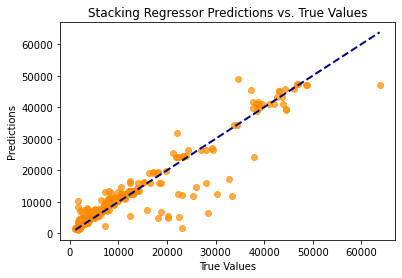

In [11]:
# StackingTransformer를 만든다.
stack = StackingTransformer(estimators, 
                            regression=True,  # 회귀 문제를 위해 True로 설정
                            n_folds=4, stratified=False, shuffle=True, 
                            random_state=0, verbose=2) 

# StackingTransformer에 X_train, y_train을 이용해 학습한다.
# transform() 함수를 이용하여 변환한다.
stack = stack.fit(X_train, y_train)

S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

# 2단계 모델을 GradientBoostingRegressor로 설정
model = GradientBoostingRegressor(random_state=0, n_estimators=100)

# 2단계 모델을 학습.
model = model.fit(S_train, y_train) 

# 학습된 2단계 모델을 가지고 예측한다.
y_pred = model.predict(S_test) 

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE 계산
print('Final RMSE: %.4f' % rmse)  # RMSE 출력
print('Final R2 Score: %.4f' % r2_score(y_test, y_pred))

# 예측 결과와 실제 값을 비교하는 산점도 그리기
plt.figure()
plt.scatter(y_test, y_pred, color='darkorange', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='navy', lw=2, linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Stacking Regressor Predictions vs. True Values')
plt.show()